# CS675 Introduction to Data Science - Project #2

**Aayushi Verma (#U01865004)**

The aim of this project is to build machine learning models for a dataset and evaluate the models. We will start by cleaning the dataset, then building machine learning models according to the brief provided. We will derive meaningful results from the models and compare them to each other to find the best model.

The dataset is a CSV file containing data about customer churn from the telecommunication industry. Churn is an important metric for businesses to analyze because high churn rates indicate unsatisfied customers, whereas low churn rates indicate satisfied customers, i.e. customers are less likely to leave this company and take their business elsewhere. Therefore it is important for companies to be able to understand their churn rates, predict future churn rates, and optimize their services to have continuing low churn rates.

According to the brief, we are to use the following four algorithms on the dataset:
1. Naive Bayes
2. Logistic Regression
3. Random Forest
4. XGBoost

We use these four models in three stages of analysis:
1. normally
2. using SMOTE techniques for addressing data imbalance
3. normally, but using hyperparameter tuning to optimize the model (only Random Forest and XGBoost)

We will compare the following metrics for each model and analysis stage:
1. Accuracy
2. Precision
3. Recall
4. F1 Score

We will be using Recall as the defining metric to evaluate these models and stages of analysis. Finally we will evaluate the best model and stage of analysis for this dataset in predicting churn.

## Step One: Data Preparation

This code is derived from my code for [Project #1](https://github.com/awesomecosmos/CS675-Intro-To-Data-Science/tree/main/Project1), where I alread performed Exploratory Data Analysis (EDA) on the same dataset. In this section, I have simply copy-pasted my earlier code for cleaning the data.

In [1]:
# importing packages for data cleaning, visualization, and EDA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly
import statsmodels
import pandas_profiling as pd_pr
import sweetviz as sv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# reading the raw CSV data file
df = pd.read_csv("telco-customer-churn.csv")

In [3]:
# getting unique values from each column, so we know which values to convert to numerical
for col in df.columns:
    print(col,df[col].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

In [4]:
# performing label encoding 
for col in df.columns:
    # we will only use 0 and 1 for binary values
    df.loc[df[col] == "Yes", col] = 1
    df.loc[df[col] == "No", col] = 0
    df.loc[df[col] == "Female", col] = 0
    df.loc[df[col] == "Male", col] = 1
    # everything else we will represent with a distinct integer
    df.loc[df[col] == "No phone service", col] = 2
    df.loc[df[col] == "No internet service", col] = 3
    df.loc[df[col] == "DSL", col] = 4
    df.loc[df[col] == "Fiber optic", col] = 5
    df.loc[df[col] == "Month-to-month", col] = 6
    df.loc[df[col] == "One year", col] = 7
    df.loc[df[col] == "Two year", col] = 8
    df.loc[df[col] == "Electronic check", col] = 9
    df.loc[df[col] == "Mailed check", col] = 10
    df.loc[df[col] == "Bank transfer (automatic)", col] = 11
    df.loc[df[col] == "Credit card (automatic)", col] = 12
    # we will set missing values to -1, so that we know that these correspond to missing values
    df.loc[df[col] == " ", col] = -1

In [5]:
# obtaining list of all columns which we need to convert
cols_to_convert_to_int = df.columns[np.where(df.dtypes=="object")]
cols_to_convert_to_int = cols_to_convert_to_int[1:] # we are excluding the customerID column

In [6]:
# converting each of the targeted columns to integer type
for col in cols_to_convert_to_int:
    df[col] = pd.to_numeric(df[col])

In [7]:
# checking the data types
df.dtypes

customerID           object
gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [8]:
df = df.drop([0])

Now that we have a dataset ready for analysis, we will split the dataset into training and testing splits, using the 80/20% ratio.

In [9]:
X = df.drop(['customerID','Churn'],axis=1)
Y = df['Churn']
# splitting the data into an 80% training/20% testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
# defining some empty dfs to record metrics from each model and stage of analysis
column_names = ["method","accuracy","precision","recall","f1"]
final_results_no_smote = pd.DataFrame(columns=column_names)
final_results_smote = pd.DataFrame(columns=column_names)
final_results_hyp = pd.DataFrame(columns=column_names)

## Step Two: Predictions (no SMOTE, no Hyperparameter Tuning)

### Naive Bayes

In [11]:
# naive bayes
nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_predictions = nb.predict(X_test)

In [12]:
nb_accuracy_score = accuracy_score(Y_test,nb_predictions)
nb_precision_score = precision_score(Y_test,nb_predictions)
nb_recall_score = recall_score(Y_test,nb_predictions)
nb_f1_score = f1_score(Y_test,nb_predictions)
nb_confusion = confusion_matrix(Y_test,nb_predictions)

In [13]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Naive Bayes",nb_accuracy_score,nb_precision_score,nb_recall_score,nb_f1_score]

### Logistic Regression

In [14]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, Y_train)
lr_predictions = lr.predict(X_test)

In [15]:
lr_accuracy_score = accuracy_score(Y_test,lr_predictions)
lr_precision_score = precision_score(Y_test,lr_predictions)
lr_recall_score = recall_score(Y_test,lr_predictions)
lr_f1_score = f1_score(Y_test,lr_predictions)
lr_confusion = confusion_matrix(Y_test,lr_predictions)

In [16]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Logistic Regression",lr_accuracy_score,lr_precision_score,lr_recall_score,lr_f1_score]

### Random Forest

In [17]:
rf = RandomForestRegressor(random_state = 42)#n_estimators = 1000, random_state = 42
rf.fit(X_train, Y_train)
rf_predictions = rf.predict(X_test)

In [18]:
rf_predictions = [int(x) for x in np.round(rf_predictions,0)]

In [19]:
rf_accuracy_score = accuracy_score(Y_test,rf_predictions)
rf_precision_score = precision_score(Y_test,rf_predictions)
rf_recall_score = recall_score(Y_test,rf_predictions)
rf_f1_score = f1_score(Y_test,rf_predictions)
rf_confusion = confusion_matrix(Y_test,rf_predictions)

In [20]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Random Forest",rf_accuracy_score,rf_precision_score,rf_recall_score,rf_f1_score]

### XGB Boost

In [21]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,Y_train)
xgb_predictions = xgb_classifier.predict(X_test)

In [22]:
xgb_accuracy_score = accuracy_score(Y_test,xgb_predictions)
xgb_precision_score = precision_score(Y_test,xgb_predictions)
xgb_recall_score = recall_score(Y_test,xgb_predictions)
xgb_f1_score = f1_score(Y_test,xgb_predictions)
xgb_confusion = confusion_matrix(Y_test,xgb_predictions)

In [23]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["XGBoost",xgb_accuracy_score,xgb_precision_score,xgb_recall_score,xgb_f1_score]

### Comparing Results (no SMOTE, no Hyperparameter Tuning)

Now that we have built all four models for this stage of analysis (no SMOTE, no hyperparameter tuning), we will compare the metrics of these models.

In [68]:
final_results_no_smote

,method,accuracy,precision,recall,f1
0,Naive Bayes,0.652236,0.415323,0.848901,0.557762
1,Logistic Regression,0.810504,0.652038,0.571429,0.609078
2,Random Forest,0.789922,0.604938,0.538462,0.569767
3,XGBoost,0.800568,0.625378,0.568681,0.595683


([<matplotlib.axis.XTick at 0x1438460b0>,
 [Text(0, 0, 'Naive Bayes'),
  Text(1, 0, 'Logistic Regression'),
  Text(2, 0, 'Random Forest'),
  Text(3, 0, 'XGBoost')])

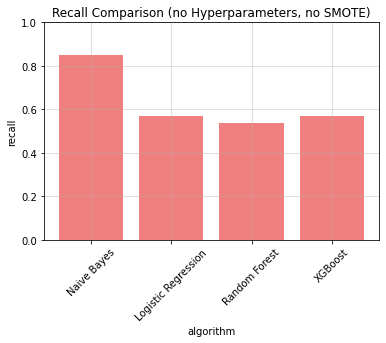

In [24]:
x_labels = final_results_no_smote['method']
indices = np.arange(len(x_labels))

plt.bar(x_labels,final_results_no_smote['recall'],color="lightcoral",alpha=1)
plt.grid(True,alpha=0.5)
plt.ylim(0,1)
plt.xlabel("algorithm")
plt.ylabel("recall")
plt.title("Recall Comparison (no Hyperparameters, no SMOTE)")
plt.xticks(indices, x_labels, rotation=45)

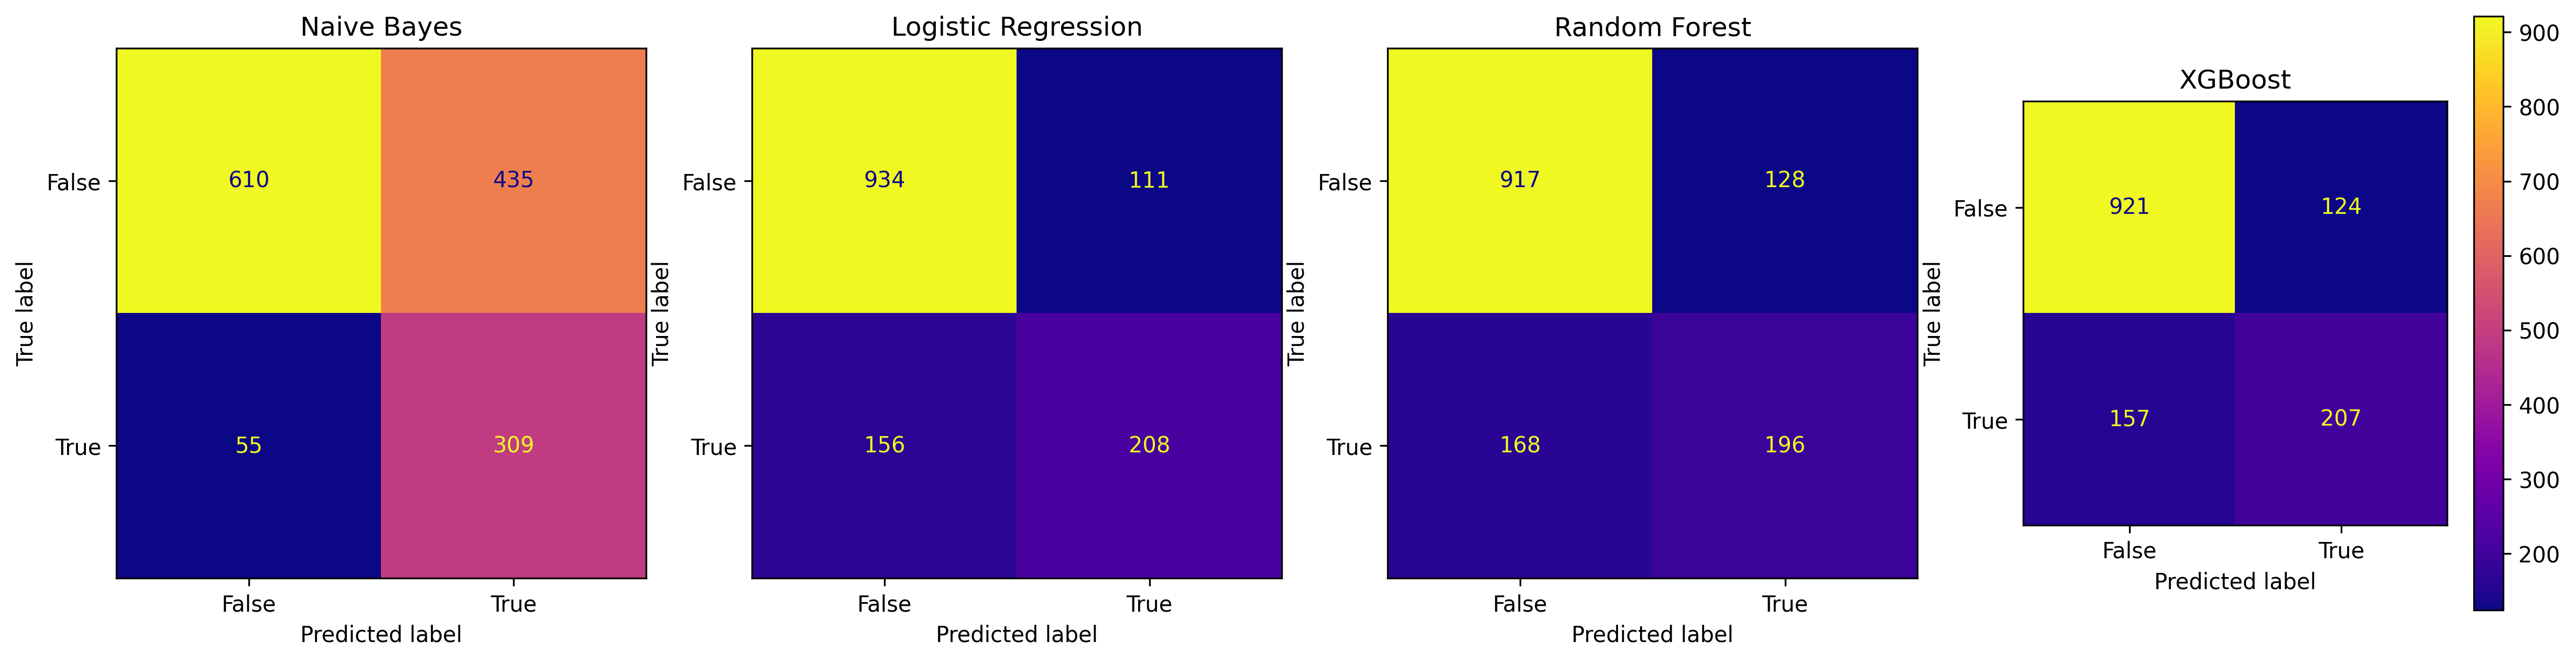

In [25]:
fig, ax = plt.subplots(1,4,sharex=True, sharey=False, figsize=(20, 5), dpi=300)
ax[0].set_title(x_labels[0])
ax[1].set_title(x_labels[1])
ax[2].set_title(x_labels[2])
ax[3].set_title(x_labels[3])

ConfusionMatrixDisplay(nb_confusion,display_labels=[False,True]).plot(ax=ax[0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(lr_confusion,display_labels=[False,True]).plot(ax=ax[1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(rf_confusion,display_labels=[False,True]).plot(ax=ax[2],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(xgb_confusion,display_labels=[False,True]).plot(ax=ax[3],cmap='plasma',colorbar=True)
fig.show()

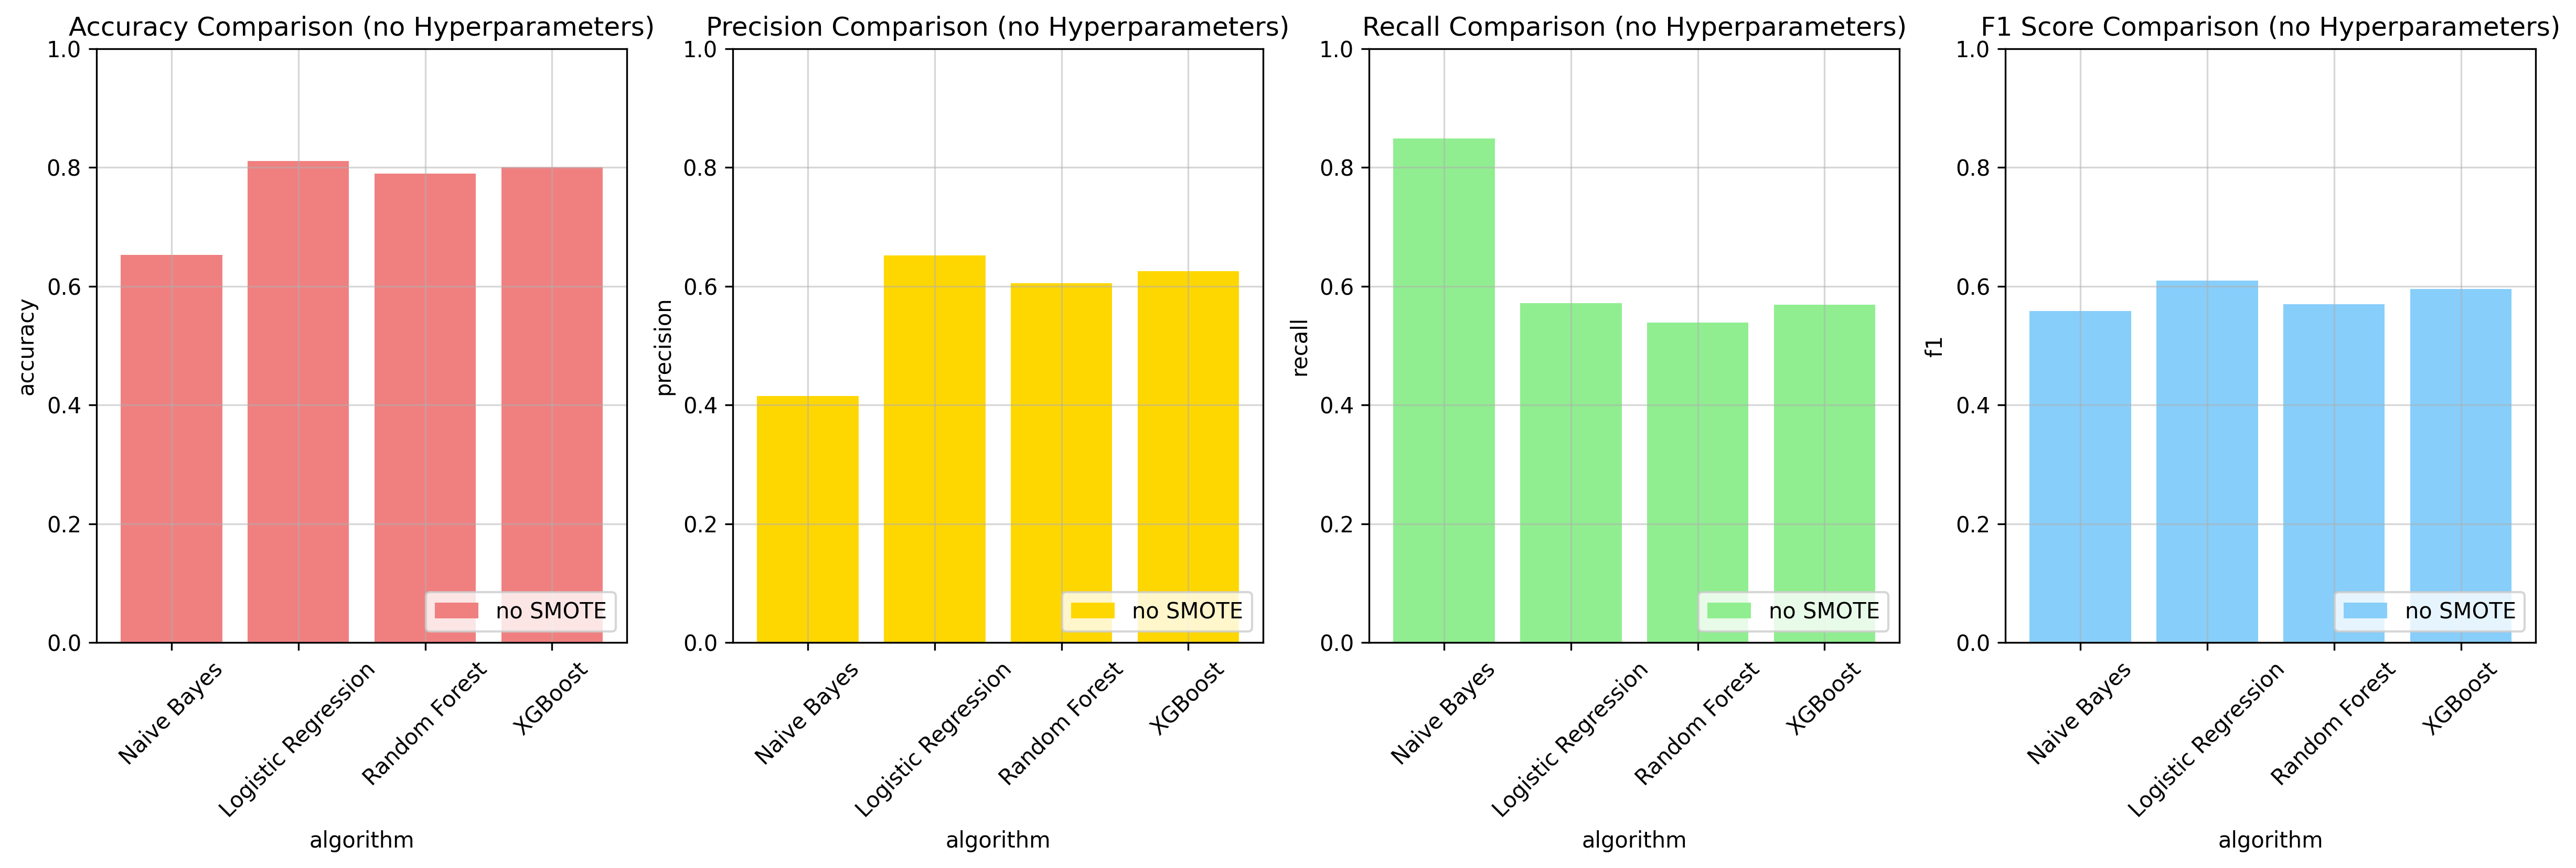

In [27]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = final_results_no_smote['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices,final_results_no_smote['accuracy'],color="lightcoral",alpha=1,label="no SMOTE") 
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison (no Hyperparameters)")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,final_results_no_smote['precision'],color="gold",alpha=1,label="no SMOTE") 
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison (no Hyperparameters)")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,final_results_no_smote['recall'],color="lightgreen",alpha=1,label="no SMOTE") 
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison (no Hyperparameters)")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,final_results_no_smote['f1'],color="lightskyblue",alpha=1,label="no SMOTE") 
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison (no Hyperparameters)")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

## Predictions (with SMOTE)

In [28]:
X = df.drop(['customerID','Churn'],axis=1)
Y = df['Churn']
# splitting the data into an 80% training/20% testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [29]:
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X_train, Y_train)

### Naive Bayes

In [30]:
# naive bayes
nb_smote = GaussianNB()
nb_smote.fit(X_res, Y_res)
nb_smote_predictions = nb_smote.predict(X_test)

In [31]:
nb_smote_accuracy_score = accuracy_score(Y_test,nb_smote_predictions)
nb_smote_precision_score = precision_score(Y_test,nb_smote_predictions)
nb_smote_recall_score = recall_score(Y_test,nb_smote_predictions)
nb_smote_f1_score = f1_score(Y_test,nb_smote_predictions)
nb_smote_confusion = confusion_matrix(Y_test,nb_smote_predictions)

In [32]:
final_results_smote.loc[len(final_results_smote)] = ["Naive Bayes",nb_smote_accuracy_score,nb_smote_precision_score,nb_smote_recall_score,nb_smote_f1_score]

### Logistic Regression (SMOTE)

In [33]:
lr_smote = LogisticRegression(random_state=0)
lr_smote.fit(X_res, Y_res)
lr_smote_predictions = lr_smote.predict(X_test)

In [34]:
lr_smote_accuracy_score = accuracy_score(Y_test,lr_smote_predictions)
lr_smote_precision_score = precision_score(Y_test,lr_smote_predictions)
lr_smote_recall_score = recall_score(Y_test,lr_smote_predictions)
lr_smote_f1_score = f1_score(Y_test,lr_smote_predictions)
lr_smote_confusion = confusion_matrix(Y_test,lr_smote_predictions)

In [35]:
final_results_smote.loc[len(final_results_smote)] = ["Logistic Regression",lr_smote_accuracy_score,lr_smote_precision_score,lr_smote_recall_score,lr_smote_f1_score]

### Random Forest (SMOTE)

In [36]:
rf_smote = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_smote.fit(X_res, Y_res)
rf_smote_predictions = rf_smote.predict(X_test)
rf_smote_predictions = [int(x) for x in np.round(rf_smote_predictions,0)]

In [37]:
rf_smote_accuracy_score = accuracy_score(Y_test,rf_smote_predictions)
rf_smote_precision_score = precision_score(Y_test,rf_smote_predictions)
rf_smote_recall_score = recall_score(Y_test,rf_smote_predictions)
rf_smote_f1_score = f1_score(Y_test,rf_smote_predictions)
rf_smote_confusion = confusion_matrix(Y_test,rf_smote_predictions)

In [38]:
final_results_smote.loc[len(final_results_smote)] = ["Random Forest",rf_smote_accuracy_score,rf_smote_precision_score,rf_smote_recall_score,rf_smote_f1_score]

### XGB Boost (SMOTE)

In [39]:
xgb_smote = xgb.XGBClassifier()
xgb_smote.fit(X_res, Y_res)
xgb_smote_predictions = xgb_smote.predict(X_test)

In [40]:
xgb_smote_accuracy_score = accuracy_score(Y_test,xgb_smote_predictions)
xgb_smote_precision_score = precision_score(Y_test,xgb_smote_predictions)
xgb_smote_recall_score = recall_score(Y_test,xgb_smote_predictions)
xgb_smote_f1_score = f1_score(Y_test,xgb_smote_predictions)
xgb_smote_confusion = confusion_matrix(Y_test,xgb_smote_predictions)

In [41]:
final_results_smote.loc[len(final_results_smote)] = ["XGBoost",xgb_smote_accuracy_score,xgb_smote_precision_score,xgb_smote_recall_score,xgb_smote_f1_score]

### Comparing Results (with SMOTE, no Hyperparameter Tuning)

Now that we have built all four models for this stage of analysis (SMOTE, no hyperparameter tuning), we will compare the metrics of these models.

In [67]:
final_results_smote

,method,accuracy,precision,recall,f1
0,Naive Bayes,0.668559,0.427567,0.835165,0.565581
1,Logistic Regression,0.740241,0.498148,0.739011,0.595133
2,Random Forest,0.777147,0.561576,0.626374,0.592208
3,XGBoost,0.761533,0.534653,0.593407,0.562500


Text(0.5, 1.0, 'Recall Comparison (no Hyperparameters, with SMOTE)')

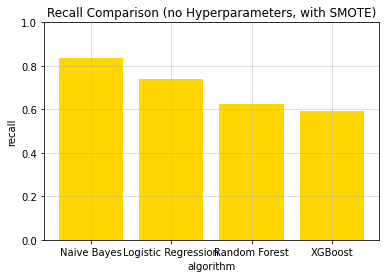

In [42]:
plt.bar(x_labels,final_results_smote['recall'],color="gold",alpha=1)
plt.grid(True,alpha=0.5)
plt.ylim(0,1)
plt.xlabel("algorithm")
plt.ylabel("recall")
plt.title("Recall Comparison (no Hyperparameters, with SMOTE)")

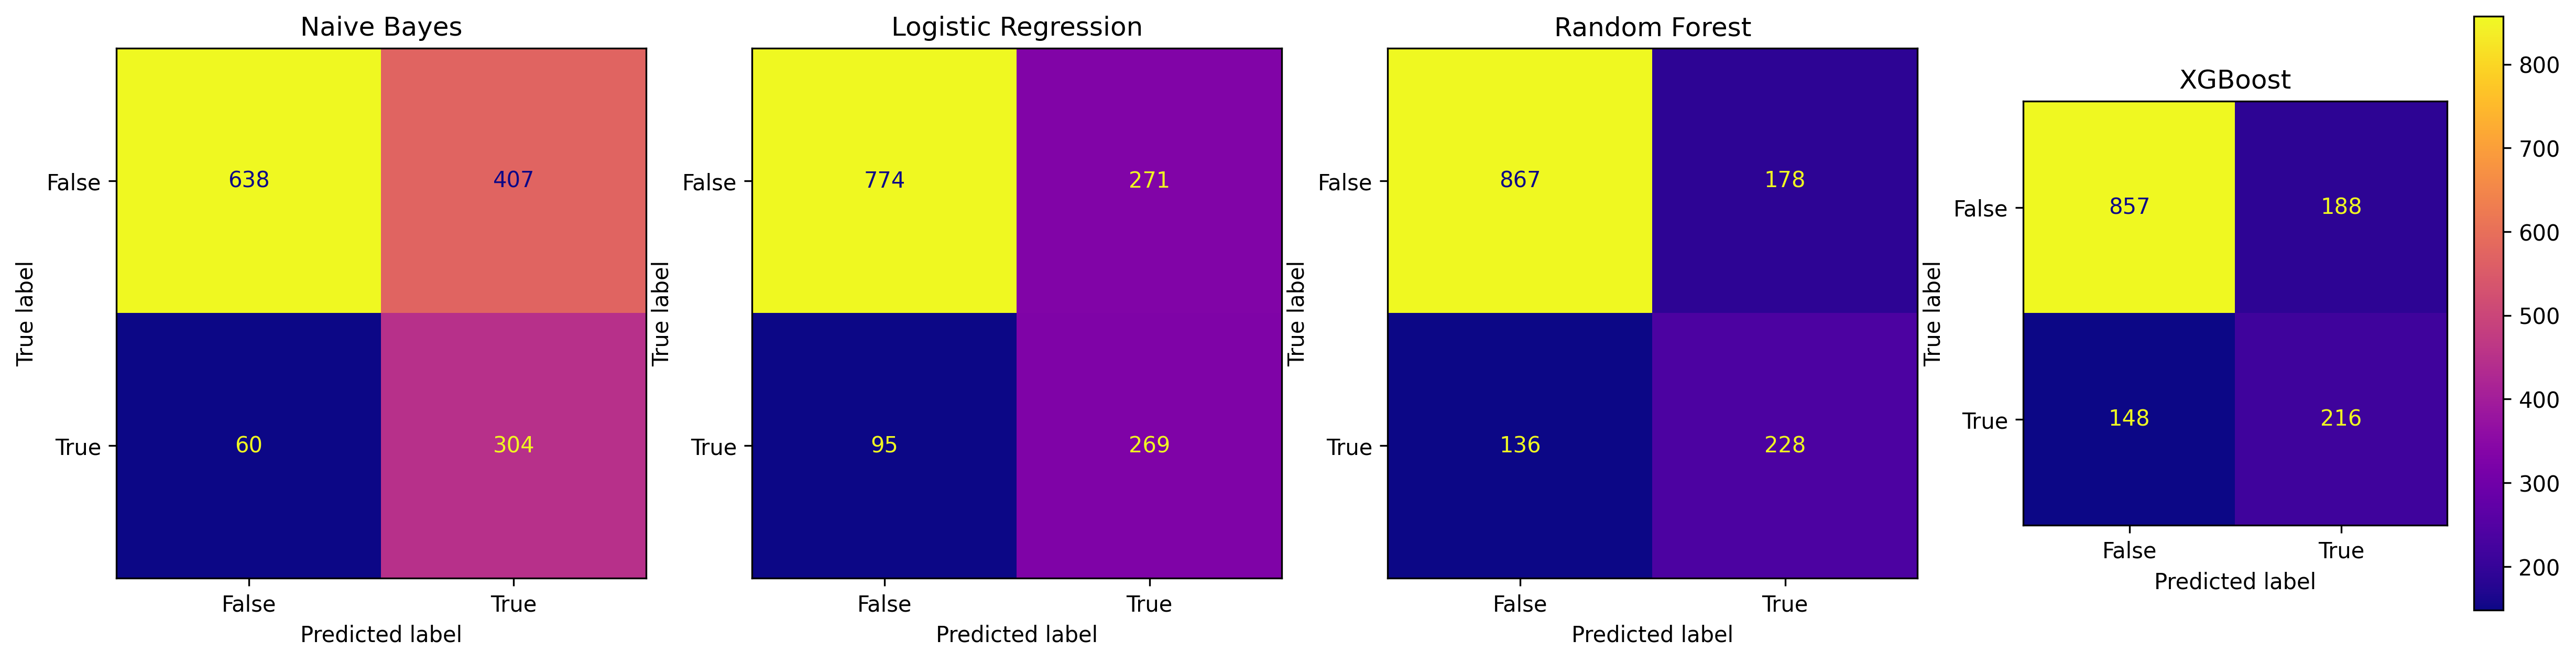

In [65]:
fig, ax = plt.subplots(1,4,sharex=True, sharey=False, figsize=(20, 5), dpi=300)
ax[0].set_title(x_labels[0])
ax[1].set_title(x_labels[1])
ax[2].set_title(x_labels[2])
ax[3].set_title(x_labels[3])

ConfusionMatrixDisplay(nb_smote_confusion,display_labels=[False,True]).plot(ax=ax[0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(lr_smote_confusion,display_labels=[False,True]).plot(ax=ax[1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(rf_smote_confusion,display_labels=[False,True]).plot(ax=ax[2],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(xgb_smote_confusion,display_labels=[False,True]).plot(ax=ax[3],cmap='plasma',colorbar=True)
fig.show()

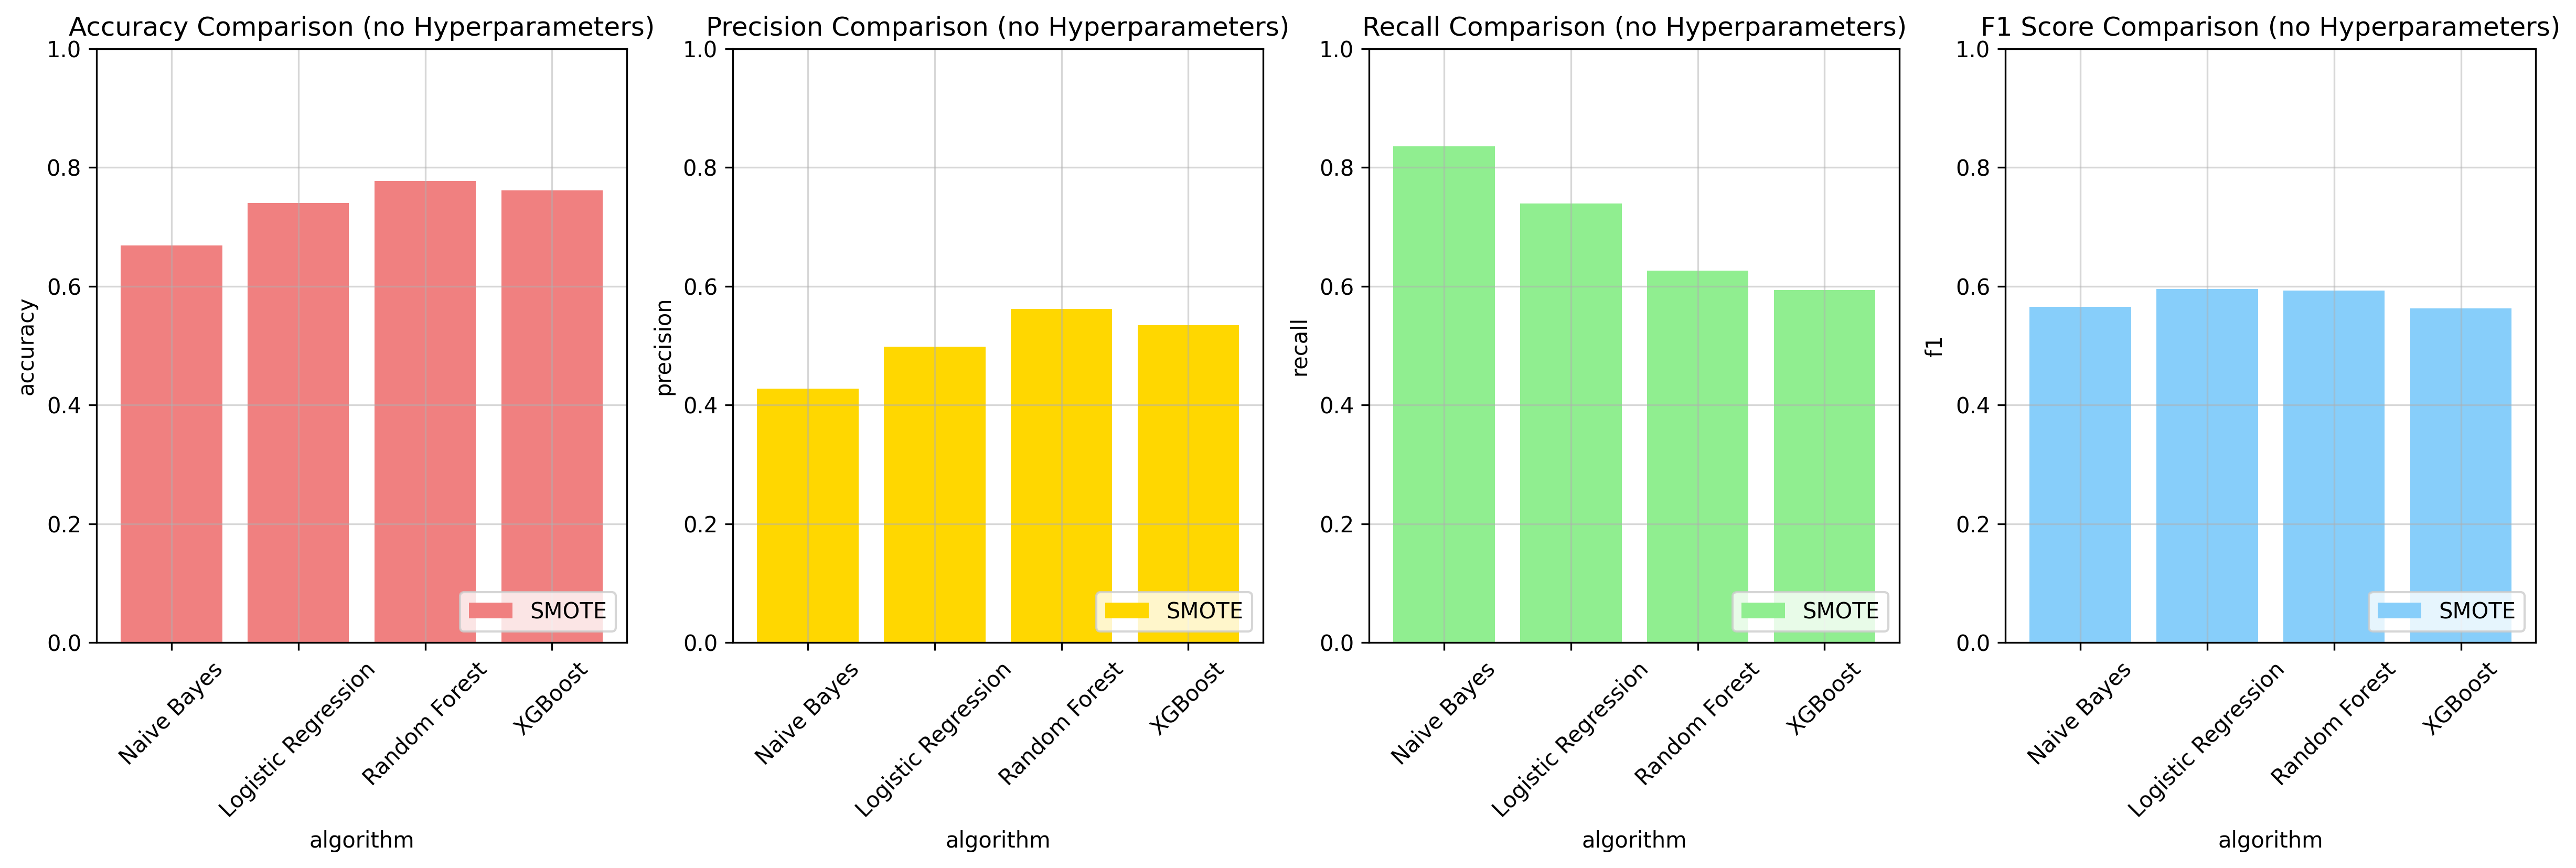

In [66]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = final_results_smote['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices,final_results_smote['accuracy'],color="lightcoral",alpha=1,label="SMOTE") 
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison (no Hyperparameters)")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,final_results_smote['precision'],color="gold",alpha=1,label="SMOTE") 
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison (no Hyperparameters)")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,final_results_smote['recall'],color="lightgreen",alpha=1,label="SMOTE") 
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison (no Hyperparameters)")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,final_results_smote['f1'],color="lightskyblue",alpha=1,label="SMOTE") 
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison (no Hyperparameters)")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

## Hyperparameter Tuning (only Random Forests and XGBoost)

### Random Forests - Hyperparameter Tuning

We will start by getting the current parameters for the Random Forest model (no SMOTE) that we obtained earlier.

In [43]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [44]:
# estimating the parameters
est_rf_params = {
    'n_estimators':np.arange(10,1000,10),
    'max_features':['auto','sqrt'],
    'max_depth':np.arange(1,11,1),
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'bootstrap':[True]
}

In [71]:
est_rf_hyp_model = RandomForestRegressor(random_state = 42)
est_rf_hyp = RandomizedSearchCV(est_rf_hyp_model,est_rf_params,n_iter=10,cv=3,n_jobs=-1)
est_rf_hyp.fit(X_train, Y_train)
est_rf_hyp_predictions = est_rf_hyp.predict(X_test)
est_rf_hyp_predictions = [int(x) for x in np.round(est_rf_hyp_predictions,0)];

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

In [46]:
est_rf_hyp_accuracy_score = accuracy_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_precision_score = precision_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_recall_score = recall_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_f1_score = f1_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_confusion = confusion_matrix(Y_test,est_rf_hyp_predictions)
final_results_hyp.loc[len(final_results_hyp)] = ["Random Forest - RandomizedSearchCV",est_rf_hyp_accuracy_score,est_rf_hyp_precision_score,est_rf_hyp_recall_score,est_rf_hyp_f1_score]

In [47]:
rf_hyp_params = est_rf_hyp.best_params_
print(rf_hyp_params)

{'n_estimators': 710, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True}


In [48]:
rf_hyp_param_values = {}
for key, value in rf_hyp_params.items():
    rf_hyp_param_values[key] = [value]

In [49]:
print(rf_hyp_param_values)

{'n_estimators': [710], 'min_samples_split': [5], 'min_samples_leaf': [4], 'max_features': ['sqrt'], 'max_depth': [8], 'bootstrap': [True]}


In [50]:
rf_hyp_model = RandomForestRegressor(random_state = 42)
rf_hyp = GridSearchCV(rf_hyp_model,rf_hyp_param_values,cv=3,n_jobs=-1)
rf_hyp.fit(X_train, Y_train)
rf_hyp_predictions = rf_hyp.predict(X_test)
rf_hyp_predictions = [int(x) for x in np.round(rf_hyp_predictions,0)]

In [51]:
rf_hyp_accuracy_score = accuracy_score(Y_test,rf_hyp_predictions)
rf_hyp_precision_score = precision_score(Y_test,rf_hyp_predictions)
rf_hyp_recall_score = recall_score(Y_test,rf_hyp_predictions)
rf_hyp_f1_score = f1_score(Y_test,rf_hyp_predictions)
rf_hyp_confusion = confusion_matrix(Y_test,rf_hyp_predictions)
final_results_hyp.loc[len(final_results_hyp)] = ["Random Forest - GridSearchCV",rf_hyp_accuracy_score,rf_hyp_precision_score,rf_hyp_recall_score,rf_hyp_f1_score]

### XGBoost - Hyperparameter Tuning

In [54]:
# estimating the parameters
est_xgb_params = {
    'n_estimators':np.arange(10,1000,10),
    'max_features':['auto','sqrt'],
    'max_depth':np.arange(1,11,1),
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'bootstrap':[True]
}

In [55]:
est_xgb_hyp_model = RandomForestRegressor(random_state = 42)
est_xgb_hyp = RandomizedSearchCV(est_xgb_hyp_model,est_xgb_params,n_iter=10,cv=3,n_jobs=-1)
est_xgb_hyp.fit(X_train, Y_train)
est_xgb_hyp_predictions = est_xgb_hyp.predict(X_test)
est_xgb_hyp_predictions = [int(x) for x in np.round(est_xgb_hyp_predictions,0)];

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

In [56]:
est_xgb_hyp_accuracy_score = accuracy_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_precision_score = precision_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_recall_score = recall_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_f1_score = f1_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_confusion = confusion_matrix(Y_test,est_xgb_hyp_predictions)
final_results_hyp.loc[len(final_results_hyp)] = ["XGBoost - RandomizedSearchCV",est_xgb_hyp_accuracy_score,est_xgb_hyp_precision_score,est_xgb_hyp_recall_score,est_xgb_hyp_f1_score]

In [57]:
xgb_hyp_params = est_xgb_hyp.best_params_
print(xgb_hyp_params)

{'n_estimators': 720, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True}


In [58]:
xgb_hyp_param_values = {}
for key, value in xgb_hyp_params.items():
    xgb_hyp_param_values[key] = [value]

In [59]:
print(xgb_hyp_param_values)

{'n_estimators': [720], 'min_samples_split': [2], 'min_samples_leaf': [4], 'max_features': ['sqrt'], 'max_depth': [8], 'bootstrap': [True]}


In [60]:
xgb_hyp_model = RandomForestRegressor(random_state = 42)
xgb_hyp = GridSearchCV(xgb_hyp_model,xgb_hyp_param_values,cv=3,n_jobs=-1)
xgb_hyp.fit(X_train, Y_train)
xgb_hyp_predictions = xgb_hyp.predict(X_test)
xgb_hyp_predictions = [int(x) for x in np.round(xgb_hyp_predictions,0)];

In [61]:
xgb_hyp_accuracy_score = accuracy_score(Y_test,xgb_hyp_predictions)
xgb_hyp_precision_score = precision_score(Y_test,xgb_hyp_predictions)
xgb_hyp_recall_score = recall_score(Y_test,xgb_hyp_predictions)
xgb_hyp_f1_score = f1_score(Y_test,xgb_hyp_predictions)
xgb_hyp_confusion = confusion_matrix(Y_test,xgb_hyp_predictions)
final_results_hyp.loc[len(final_results_hyp)] = ["XGBoost - GridSearchCV",xgb_hyp_accuracy_score,xgb_hyp_precision_score,xgb_hyp_recall_score,xgb_hyp_f1_score]

### Comparing Results (Hyperparameter Tuning)

In [74]:
final_results_hyp

,method,accuracy,precision,recall,f1
0,Random Forest - RandomizedSearchCV,0.800568,0.635179,0.535714,0.581222
1,Random Forest - GridSearchCV,0.800568,0.635179,0.535714,0.581222
2,XGBoost - RandomizedSearchCV,0.801278,0.637255,0.535714,0.582090
3,XGBoost - GridSearchCV,0.801278,0.637255,0.535714,0.582090


([<matplotlib.axis.XTick at 0x1505ecd90>,
 [Text(0, 0, 'Random Forest - RandomizedSearchCV'),
  Text(1, 0, 'Random Forest - GridSearchCV'),
  Text(2, 0, 'XGBoost - RandomizedSearchCV'),
  Text(3, 0, 'XGBoost - GridSearchCV')])

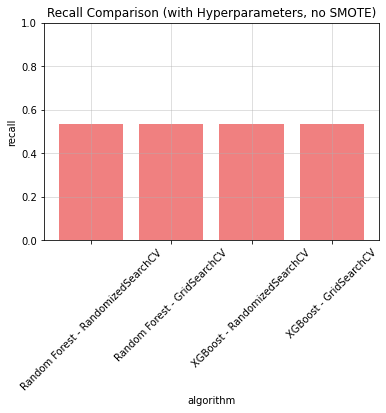

In [75]:
x_labels = final_results_hyp['method']
indices = np.arange(len(x_labels))

plt.bar(x_labels,final_results_hyp['recall'],color="lightcoral",alpha=1)
plt.grid(True,alpha=0.5)
plt.ylim(0,1)
plt.xlabel("algorithm")
plt.ylabel("recall")
plt.title("Recall Comparison (with Hyperparameters, no SMOTE)")
plt.xticks(indices, x_labels, rotation=45)

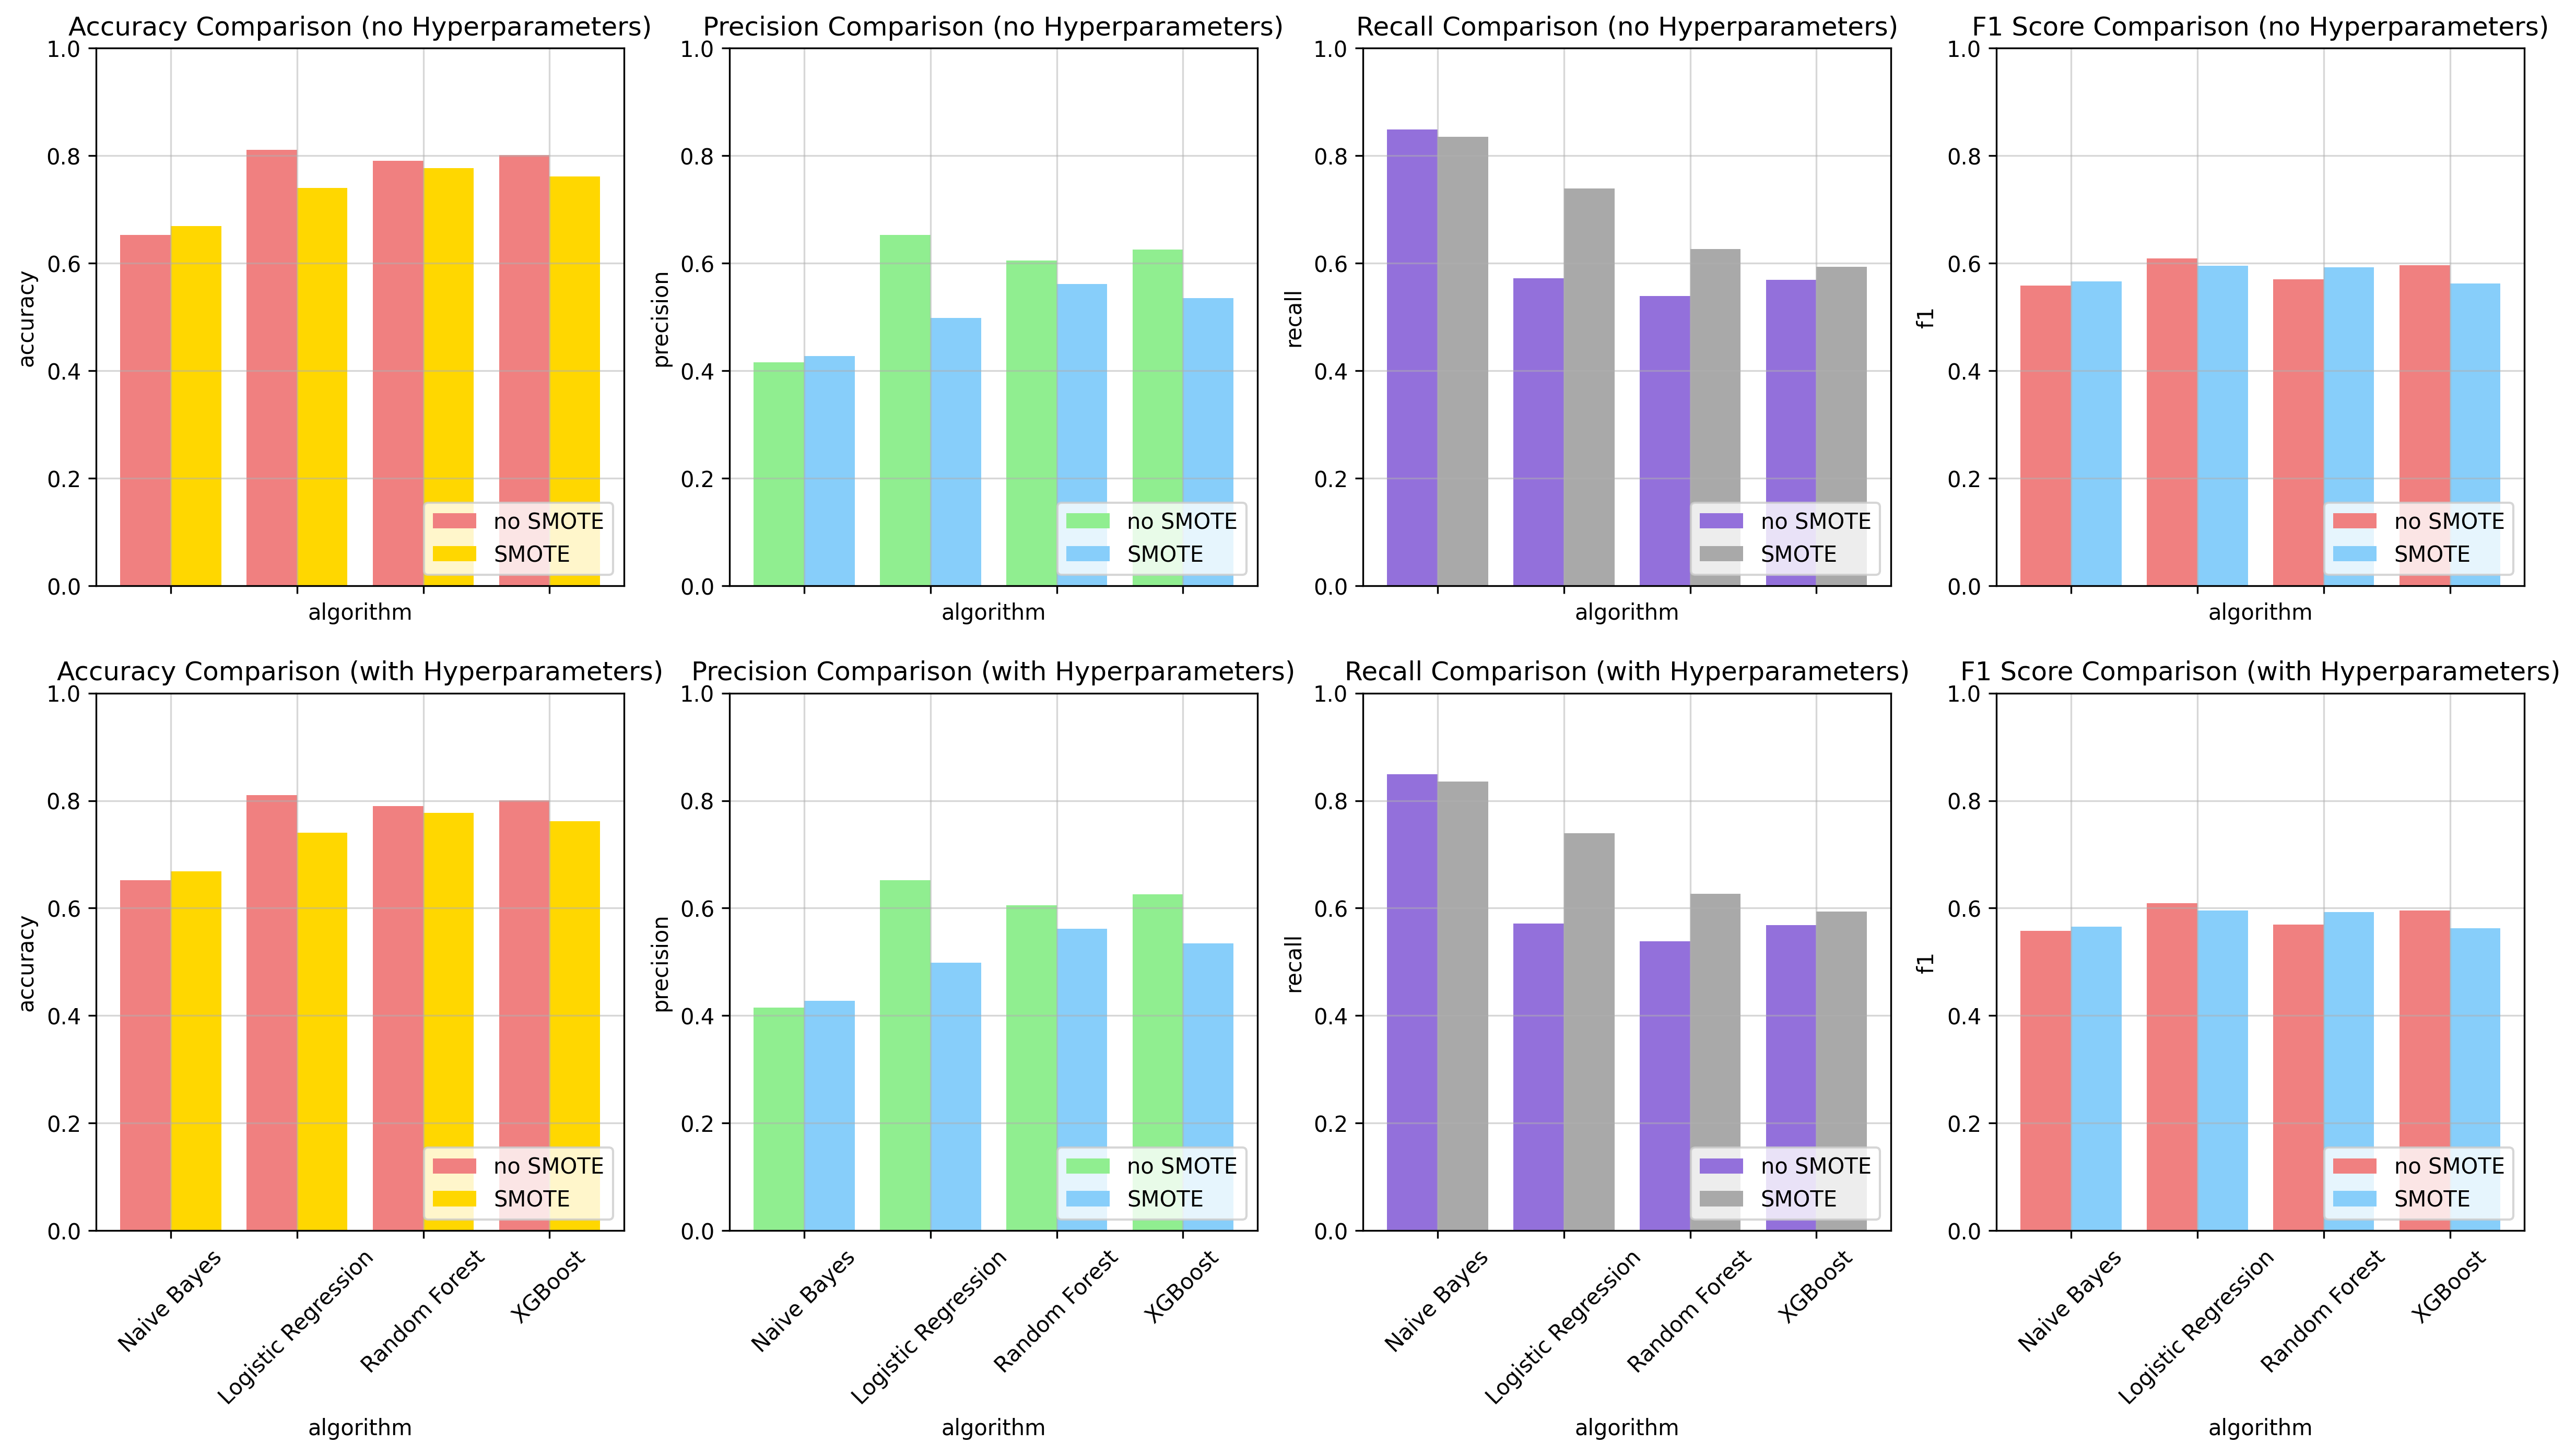

In [88]:
fig, ax = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(20, 10), dpi=300)
x_labels = final_results_no_smote['method']
indices = np.arange(len(x_labels))
width = 0.4

# first row - NO Hyperparameters
#row=0, col=0
ax[0, 0].bar(indices-0.5*width,final_results_no_smote['accuracy'],width,color="lightcoral",alpha=1,label="no SMOTE") 
ax[0, 0].bar(indices+0.5*width,final_results_smote['accuracy'],width,color="gold",alpha=1,label="SMOTE")
ax[0, 0].grid(True,alpha=0.5)
ax[0, 0].set_ylim(0,1)
ax[0, 0].set_xlabel("algorithm")
ax[0, 0].set_ylabel("accuracy")
ax[0, 0].set_title("Accuracy Comparison (no Hyperparameters)")
ax[0, 0].legend(loc='lower right')

#row=0, col=1
ax[0, 1].bar(indices-0.5*width,final_results_no_smote['precision'],width,color="lightgreen",alpha=1,label="no SMOTE") 
ax[0, 1].bar(indices+0.5*width,final_results_smote['precision'],width,color="lightskyblue",alpha=1,label="SMOTE")
ax[0, 1].grid(True,alpha=0.5)
ax[0, 1].set_ylim(0,1)
ax[0, 1].set_xlabel("algorithm")
ax[0, 1].set_ylabel("precision")
ax[0, 1].set_title("Precision Comparison (no Hyperparameters)")
ax[0, 1].legend(loc='lower right')

#row=0, col=2
ax[0, 2].bar(indices-0.5*width,final_results_no_smote['recall'],width,color="mediumpurple",alpha=1,label="no SMOTE") 
ax[0, 2].bar(indices+0.5*width,final_results_smote['recall'],width,color="darkgrey",alpha=1,label="SMOTE")
ax[0, 2].grid(True,alpha=0.5)
ax[0, 2].set_ylim(0,1)
ax[0, 2].set_xlabel("algorithm")
ax[0, 2].set_ylabel("recall")
ax[0, 2].set_title("Recall Comparison (no Hyperparameters)")
ax[0, 2].legend(loc='lower right')

#row=0, col=3
ax[0, 3].bar(indices-0.5*width,final_results_no_smote['f1'],width,color="lightcoral",alpha=1,label="no SMOTE") 
ax[0, 3].bar(indices+0.5*width,final_results_smote['f1'],width,color="lightskyblue",alpha=1,label="SMOTE")
ax[0, 3].grid(True,alpha=0.5)
ax[0, 3].set_ylim(0,1)
ax[0, 3].set_xlabel("algorithm")
ax[0, 3].set_ylabel("f1")
ax[0, 3].set_title("F1 Score Comparison (no Hyperparameters)")
ax[0, 3].legend(loc='lower right')


# first row - WITH Hyperparameters
#row=1, col=0
ax[1, 0].bar(indices-0.5*width,final_results_no_smote['accuracy'],width,color="lightcoral",alpha=1,label="no SMOTE") 
ax[1, 0].bar(indices+0.5*width,final_results_smote['accuracy'],width,color="gold",alpha=1,label="SMOTE")
ax[1, 0].grid(True,alpha=0.5)
ax[1, 0].set_ylim(0,1)
ax[1, 0].set_xlabel("algorithm")
ax[1, 0].set_ylabel("accuracy")
ax[1, 0].set_title("Accuracy Comparison (with Hyperparameters)")
ax[1, 0].legend(loc='lower right')
ax[1, 0].set_xticks(indices, x_labels, rotation=45)#

#row=1, col=1
ax[1, 1].bar(indices-0.5*width,final_results_no_smote['precision'],width,color="lightgreen",alpha=1,label="no SMOTE") 
ax[1, 1].bar(indices+0.5*width,final_results_smote['precision'],width,color="lightskyblue",alpha=1,label="SMOTE")
ax[1, 1].grid(True,alpha=0.5)
ax[1, 1].set_ylim(0,1)
ax[1, 1].set_xlabel("algorithm")
ax[1, 1].set_ylabel("precision")
ax[1, 1].set_title("Precision Comparison (with Hyperparameters)")
ax[1, 1].legend(loc='lower right')
ax[1, 1].set_xticks(indices, x_labels, rotation=45)#

#row=1, col=2
ax[1, 2].bar(indices-0.5*width,final_results_no_smote['recall'],width,color="mediumpurple",alpha=1,label="no SMOTE") 
ax[1, 2].bar(indices+0.5*width,final_results_smote['recall'],width,color="darkgrey",alpha=1,label="SMOTE")
ax[1, 2].grid(True,alpha=0.5)
ax[1, 2].set_ylim(0,1)
ax[1, 2].set_xlabel("algorithm")
ax[1, 2].set_ylabel("recall")
ax[1, 2].set_title("Recall Comparison (with Hyperparameters)")
ax[1, 2].legend(loc='lower right')
ax[1, 2].set_xticks(indices, x_labels, rotation=45)#

#row=0, col=3
ax[1, 3].bar(indices-0.5*width,final_results_no_smote['f1'],width,color="lightcoral",alpha=1,label="no SMOTE") 
ax[1, 3].bar(indices+0.5*width,final_results_smote['f1'],width,color="lightskyblue",alpha=1,label="SMOTE")
ax[1, 3].grid(True,alpha=0.5)
ax[1, 3].set_ylim(0,1)
ax[1, 3].set_xlabel("algorithm")
ax[1, 3].set_ylabel("f1")
ax[1, 3].set_title("F1 Score Comparison (with Hyperparameters)")
ax[1, 3].legend(loc='lower right')
ax[1, 3].set_xticks(indices, x_labels, rotation=45)#

In [93]:
final_results_hyp

,method,accuracy,precision,recall,f1
0,Random Forest - RandomizedSearchCV,0.800568,0.635179,0.535714,0.581222
1,Random Forest - GridSearchCV,0.800568,0.635179,0.535714,0.581222
2,XGBoost - RandomizedSearchCV,0.801278,0.637255,0.535714,0.582090
3,XGBoost - GridSearchCV,0.801278,0.637255,0.535714,0.582090


In [94]:
(indices+1.5*width)[2]

2.15

## Comparison of non-SMOTE vs SMOTE Metrics

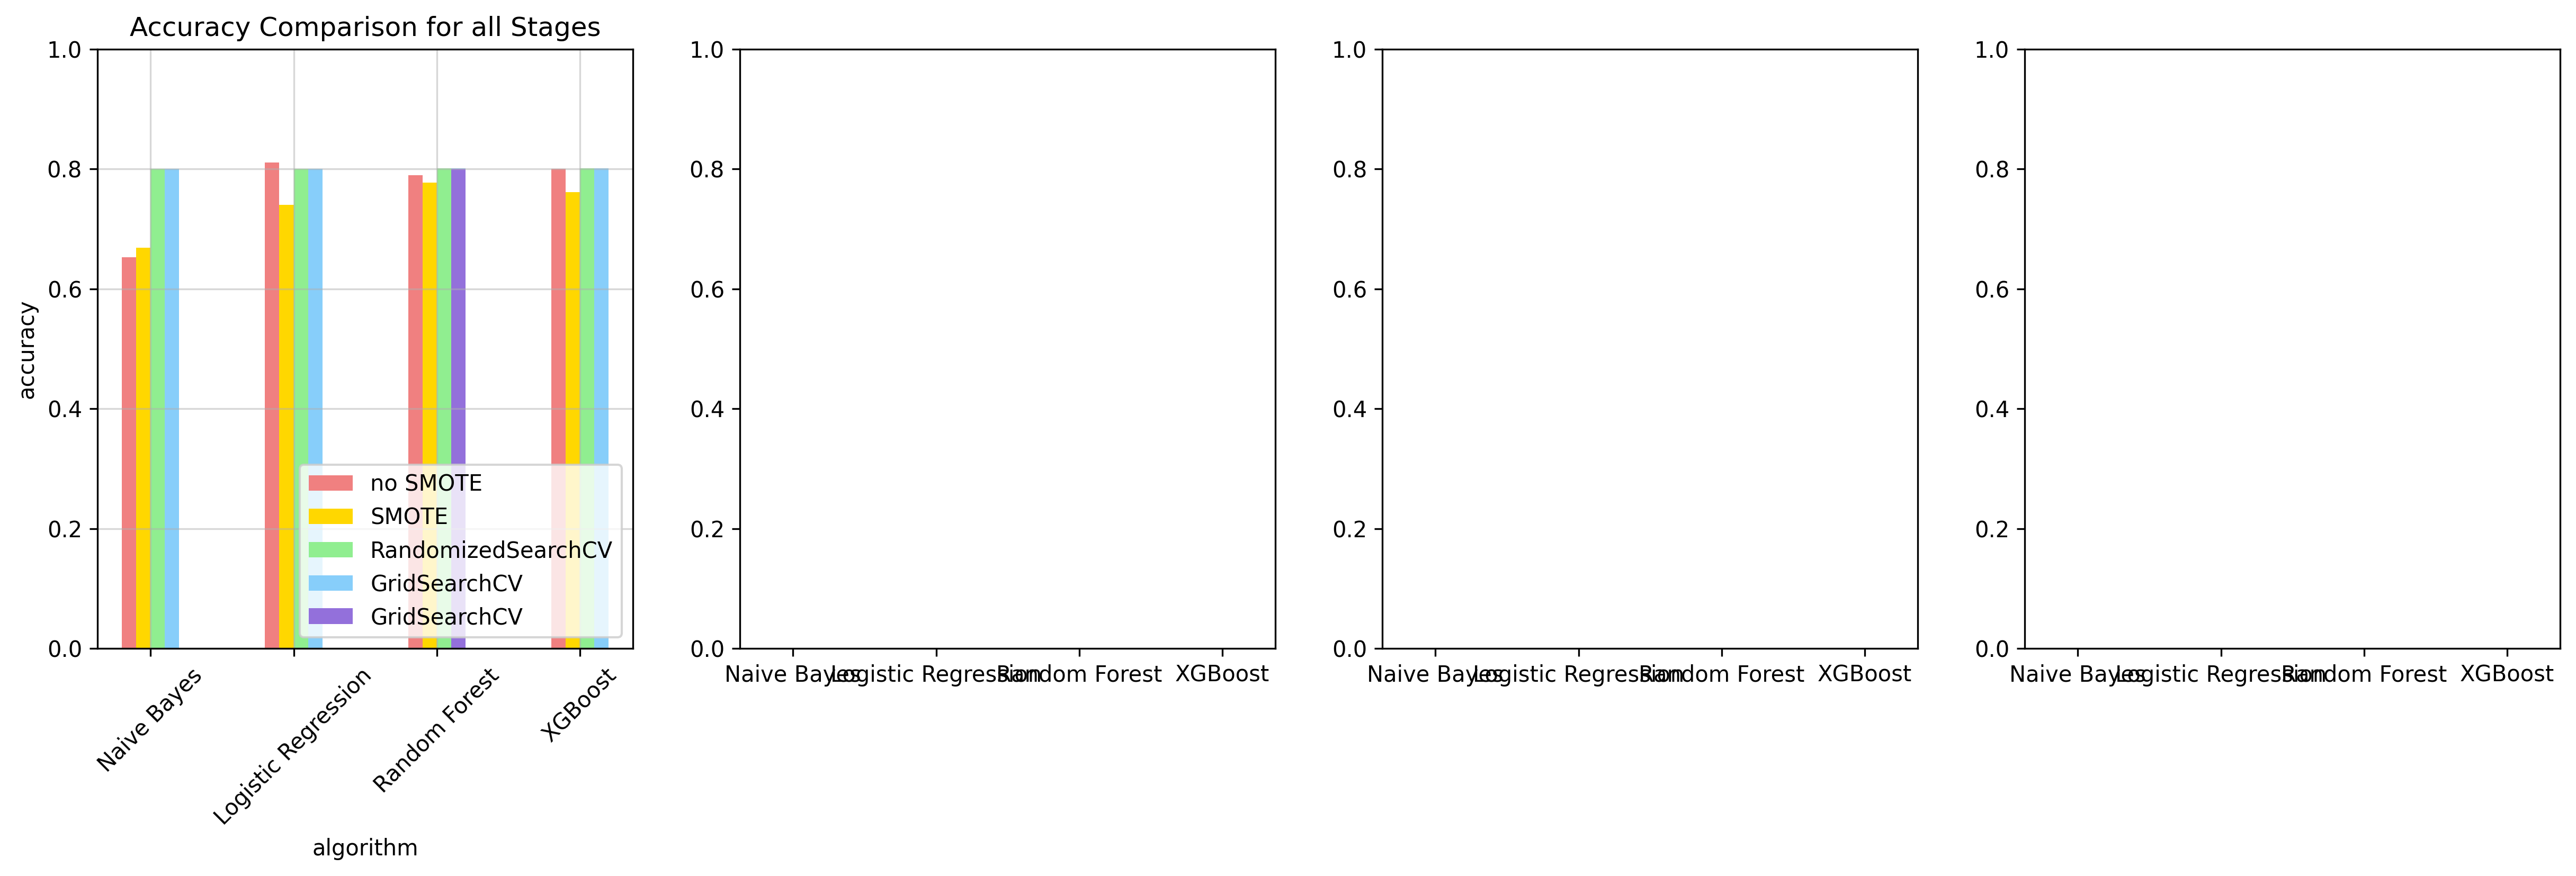

In [96]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = final_results_no_smote['method']
indices = np.arange(len(x_labels))
width = 0.1

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices-1.5*width,final_results_no_smote['accuracy'],width,color="lightcoral",alpha=1,label="no SMOTE") 
ax[0].bar(indices-0.5*width,final_results_smote['accuracy'],width,color="gold",alpha=1,label="SMOTE") 
ax[0].bar(indices+0.5*width,final_results_hyp['accuracy'],width,color="lightgreen",alpha=1,label="RandomizedSearchCV") 
ax[0].bar(indices+1.5*width,final_results_hyp['accuracy'],width,color="lightskyblue",alpha=1,label="GridSearchCV")
ax[0].bar((indices+1.5*width)[2],final_results_hyp['accuracy'][0],width,color="mediumpurple",alpha=1,label="GridSearchCV")
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison for all Stages")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)#

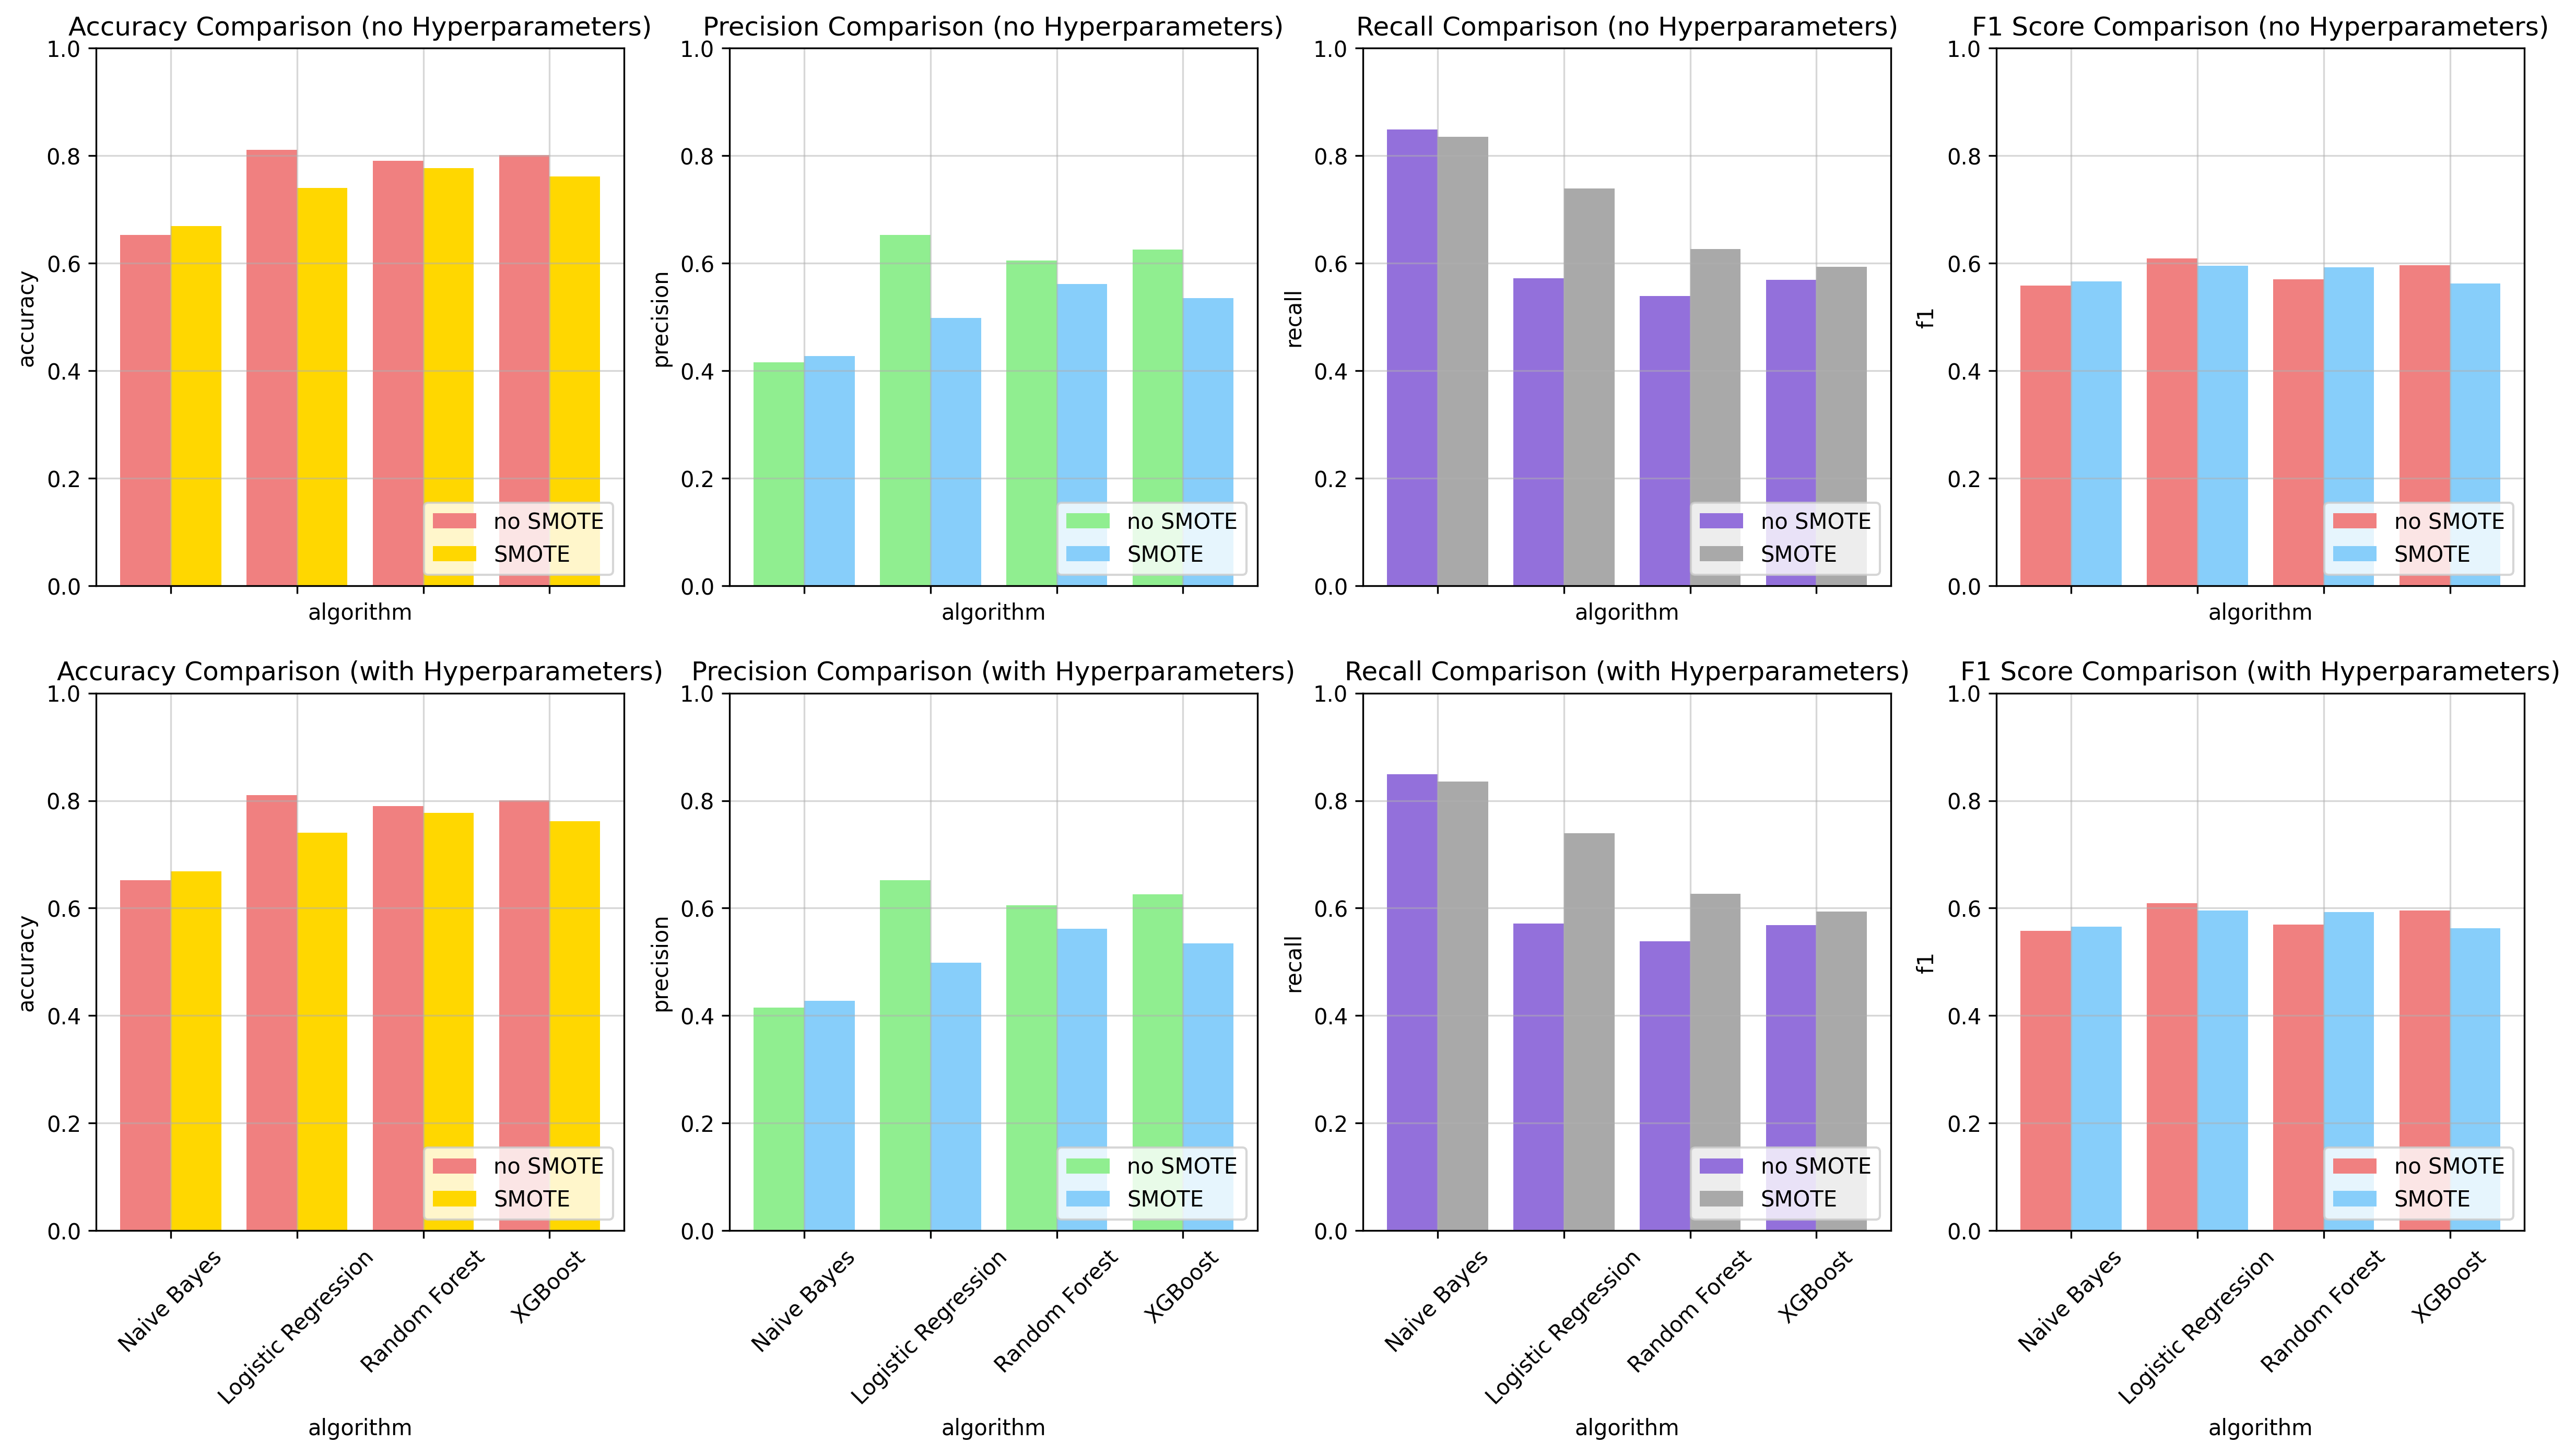

In [63]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 10), dpi=300)
x_labels = final_results_no_smote['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0, 0].bar(indices-0.1*width,final_results_no_smote['accuracy'],width,color="lightcoral",alpha=1,label="no SMOTE") 
ax[0, 0].bar(indices+0.1*width,final_results_smote['accuracy'],width,color="gold",alpha=1,label="SMOTE")
ax[0, 0].grid(True,alpha=0.5)
ax[0, 0].set_ylim(0,1)
ax[0, 0].set_xlabel("algorithm")
ax[0, 0].set_ylabel("accuracy")
ax[0, 0].set_title("Accuracy Comparison (no Hyperparameters)")
ax[0, 0].legend(loc='lower right')

#row=0, col=1
ax[0, 1].bar(indices-0.5*width,final_results_no_smote['precision'],width,color="lightgreen",alpha=1,label="no SMOTE") 
ax[0, 1].bar(indices+0.5*width,final_results_smote['precision'],width,color="lightskyblue",alpha=1,label="SMOTE")
ax[0, 1].grid(True,alpha=0.5)
ax[0, 1].set_ylim(0,1)
ax[0, 1].set_xlabel("algorithm")
ax[0, 1].set_ylabel("precision")
ax[0, 1].set_title("Precision Comparison (no Hyperparameters)")
ax[0, 1].legend(loc='lower right')

#row=0, col=2
ax[0, 2].bar(indices-0.5*width,final_results_no_smote['recall'],width,color="mediumpurple",alpha=1,label="no SMOTE") 
ax[0, 2].bar(indices+0.5*width,final_results_smote['recall'],width,color="darkgrey",alpha=1,label="SMOTE")
ax[0, 2].grid(True,alpha=0.5)
ax[0, 2].set_ylim(0,1)
ax[0, 2].set_xlabel("algorithm")
ax[0, 2].set_ylabel("recall")
ax[0, 2].set_title("Recall Comparison (no Hyperparameters)")
ax[0, 2].legend(loc='lower right')

#row=0, col=3
ax[0, 3].bar(indices-0.5*width,final_results_no_smote['f1'],width,color="lightcoral",alpha=1,label="no SMOTE") 
ax[0, 3].bar(indices+0.5*width,final_results_smote['f1'],width,color="lightskyblue",alpha=1,label="SMOTE")
ax[0, 3].grid(True,alpha=0.5)
ax[0, 3].set_ylim(0,1)
ax[0, 3].set_xlabel("algorithm")
ax[0, 3].set_ylabel("f1")
ax[0, 3].set_title("F1 Score Comparison (no Hyperparameters)")
ax[0, 3].legend(loc='lower right')


# first row - WITH Hyperparameters
#row=1, col=0
ax[1, 0].bar(indices-0.5*width,final_results_no_smote['accuracy'],width,color="lightcoral",alpha=1,label="no SMOTE") 
ax[1, 0].bar(indices+0.5*width,final_results_smote['accuracy'],width,color="gold",alpha=1,label="SMOTE")
ax[1, 0].grid(True,alpha=0.5)
ax[1, 0].set_ylim(0,1)
ax[1, 0].set_xlabel("algorithm")
ax[1, 0].set_ylabel("accuracy")
ax[1, 0].set_title("Accuracy Comparison (with Hyperparameters)")
ax[1, 0].legend(loc='lower right')
ax[1, 0].set_xticks(indices, x_labels, rotation=45)#

#row=1, col=1
ax[1, 1].bar(indices-0.5*width,final_results_no_smote['precision'],width,color="lightgreen",alpha=1,label="no SMOTE") 
ax[1, 1].bar(indices+0.5*width,final_results_smote['precision'],width,color="lightskyblue",alpha=1,label="SMOTE")
ax[1, 1].grid(True,alpha=0.5)
ax[1, 1].set_ylim(0,1)
ax[1, 1].set_xlabel("algorithm")
ax[1, 1].set_ylabel("precision")
ax[1, 1].set_title("Precision Comparison (with Hyperparameters)")
ax[1, 1].legend(loc='lower right')
ax[1, 1].set_xticks(indices, x_labels, rotation=45)#

#row=1, col=2
ax[1, 2].bar(indices-0.5*width,final_results_no_smote['recall'],width,color="mediumpurple",alpha=1,label="no SMOTE") 
ax[1, 2].bar(indices+0.5*width,final_results_smote['recall'],width,color="darkgrey",alpha=1,label="SMOTE")
ax[1, 2].grid(True,alpha=0.5)
ax[1, 2].set_ylim(0,1)
ax[1, 2].set_xlabel("algorithm")
ax[1, 2].set_ylabel("recall")
ax[1, 2].set_title("Recall Comparison (with Hyperparameters)")
ax[1, 2].legend(loc='lower right')
ax[1, 2].set_xticks(indices, x_labels, rotation=45)#

#row=0, col=3
ax[1, 3].bar(indices-0.5*width,final_results_no_smote['f1'],width,color="lightcoral",alpha=1,label="no SMOTE") 
ax[1, 3].bar(indices+0.5*width,final_results_smote['f1'],width,color="lightskyblue",alpha=1,label="SMOTE")
ax[1, 3].grid(True,alpha=0.5)
ax[1, 3].set_ylim(0,1)
ax[1, 3].set_xlabel("algorithm")
ax[1, 3].set_ylabel("f1")
ax[1, 3].set_title("F1 Score Comparison (with Hyperparameters)")
ax[1, 3].legend(loc='lower right')
ax[1, 3].set_xticks(indices, x_labels, rotation=45)#

([<matplotlib.axis.XTick at 0x1503e2320>,
 [Text(0, 0, 'Naive Bayes'),
  Text(1, 0, 'Logistic Regression'),
  Text(2, 0, 'Random Forest'),
  Text(3, 0, 'XGBoost')])

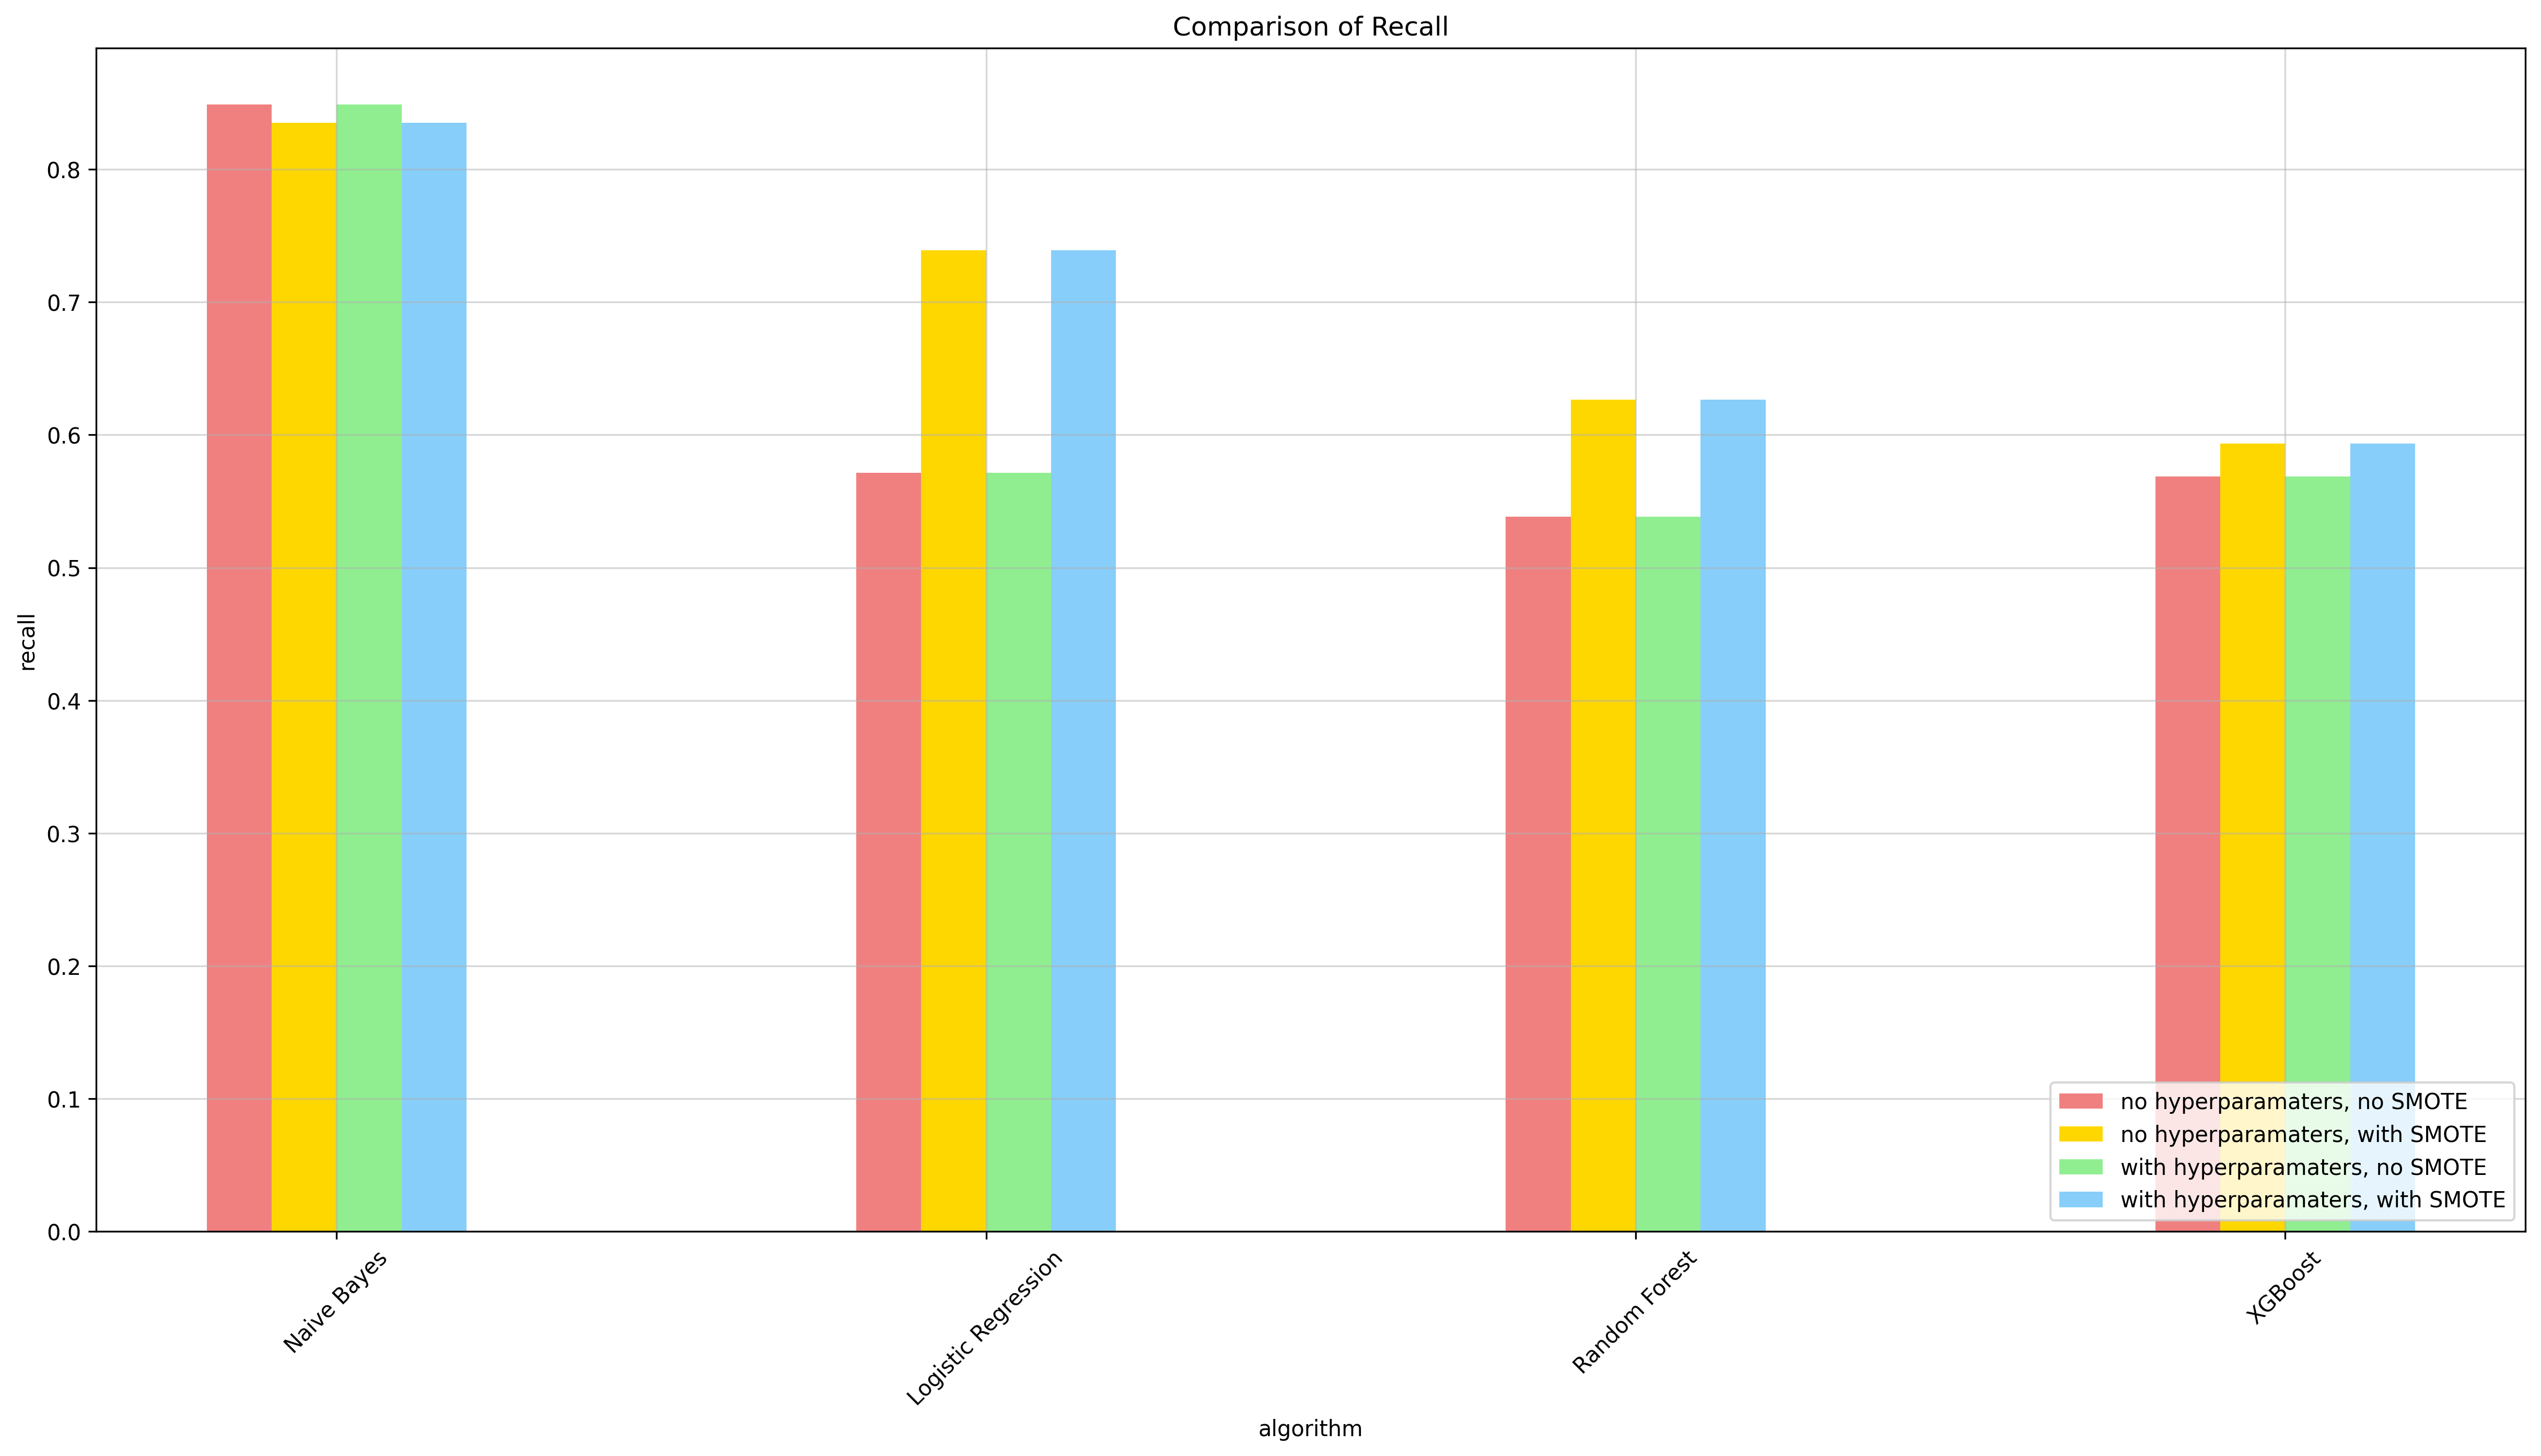

In [64]:
x_labels = final_results_no_smote['method']
indices = np.arange(len(x_labels))
width = 0.1

plt.figure(figsize=(20, 10), dpi=300)
plt.bar(indices-1.5*width,final_results_no_smote["recall"],width,color="lightcoral",alpha=1,label="no hyperparamaters, no SMOTE") 
plt.bar(indices-0.5*width,final_results_smote["recall"],width,color="gold",alpha=1,label="no hyperparamaters, with SMOTE")
plt.bar(indices+0.5*width,final_results_no_smote["recall"],width,color="lightgreen",alpha=1,label="with hyperparamaters, no SMOTE")
plt.bar(indices+1.5*width,final_results_smote["recall"],width,color="lightskyblue",alpha=1,label="with hyperparamaters, with SMOTE")
plt.grid(True,alpha=0.5)
# plt.set_ylim(0,1)
plt.xlabel("algorithm")
plt.ylabel("recall")
plt.title("Comparison of Recall")
plt.legend(loc='lower right')
plt.xticks(indices, x_labels, rotation=45)
